In [2]:
import torch
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import StandardScaler
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
import re
from num2words import num2words
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Embedding, Concatenate, AveragePooling1D, BatchNormalization, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import HeUniform
from keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
import contractions
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.utils import plot_model

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\spooj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\spooj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Read in Data 

In [1]:
import os

In [3]:
path = "C:\\Users\\spooj\\Downloads\\TruthSeeke 2024\\TruthSeeker2023"
os.chdir(path)

In [4]:
df_2 = pd.read_csv("./Features_For_Traditional_ML_Techniques.csv")
df_2_mod = df_2.drop(columns='embeddings')

## Preprocessing

### Removing stopwords

In [5]:
def remove_stopword(tweet):
    stop_words = set(stopwords.words('english'))
    filtered_tweet = [word for word in tweet.split() if word not in stop_words]
    filtered_tweet = " ".join(filtered_tweet)
    return filtered_tweet

tweets = df_2_mod['tweet']
filtered_tweets = list(map(remove_stopword, tweets))

### lemmatization

In [6]:
def lemmatization(tweet):
    lemmatizer = nltk.WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tweet.split()]
    lemmatized_tweet = " ".join(lemmatized_tokens)
    return lemmatized_tweet

lemmatized_tweet = list(map(lemmatization, filtered_tweets))

### replacing numbers with their word format

In [7]:
def replace_numbers_with_words(text):
    return re.sub(r'\b\d+\b', lambda x: num2words(int(x.group())), text)

cleaned_tweets = list(map(replace_numbers_with_words, lemmatized_tweet))


### Remove html

In [8]:
def remove_html(text):
    text = re.sub(r'http\S+', '', text.lower())
    return text
cleaned_tweets = list(map(remove_html, cleaned_tweets))

### Remove contractions

In [9]:
def remove_contractions(text): 
    return ' '.join([contractions.fix(word) for word in text.split()])

cleaned_tweets = list(map(remove_contractions, cleaned_tweets))

## Preparing the dataset for training

### Numerical Features

In [22]:
# Getting the numerical features
df_clean = df_2_mod[~df_2_mod['tweet'].isna()]
df_clean_filtered = df_clean[['followers_count', 'friends_count', 'favourites_count',
       'statuses_count', 'listed_count', 'cred', 'normalize_influence',
       'mentions', 'retweets', 'hashtags', 'URLs', 'unique_count',
       'PERSON_percentage', 'PERCENT_percentage', 'Word count',
       'Max word length', 'Average word length', 'present_verbs',
       'past_verbs', 'adjectives', 'adverbs', 'pronouns', 'TOs',
       'capitals', 'short_word_freq']]

# df_clean_filtered = df_clean[['followers_count', 'friends_count', 'favourites_count',
#        'statuses_count', 'listed_count', 'cred', 'normalize_influence',
#        'mentions', 'retweets', 'hashtags']]
# df_clean_filtered = df_clean[['followers_count', 'friends_count', 'favourites_count',
#        'statuses_count', 'listed_count', 'cred', 'normalize_influence',
#        'mentions', 'hashtags', 'URLs', 'unique_count', 'ORG_percentage',
#        'GPE_percentage', 'PERSON_percentage', 'MONEY_percentage',
#        'DATE_percentage', 'CARDINAL_percentage', 'Word count',
#        'Min word length', 'Average word length', 'present_verbs',
#        'past_verbs', 'adjectives', 'pronouns', 'TOs', 'determiners',
#        'dots', 'exclamation', 'capitals', 'short_word_freq']]
scaler = StandardScaler()
X_clean = scaler.fit_transform(df_clean_filtered)
# Getting the labels
labels = df_clean['majority_target']
labels = labels.astype(int)
labels = np.array(labels)
labels = np.reshape(labels, [-1,1])

In [103]:
len(['followers_count', 'friends_count', 'favourites_count',
       'statuses_count', 'listed_count', 'cred', 'normalize_influence',
       'mentions', 'retweets', 'hashtags', 'URLs', 'unique_count',
       'PERSON_percentage', 'PERCENT_percentage', 'Word count',
       'Max word length', 'Average word length', 'present_verbs',
       'past_verbs', 'adjectives', 'adverbs', 'pronouns', 'TOs',
       'capitals', 'short_word_freq'])

25

### Text Data

In [24]:
text_data = cleaned_tweets
tokenizer = Tokenizer(num_words= 50000)  
tokenizer.fit_on_texts(text_data)
text_sequences = tokenizer.texts_to_sequences(text_data)
max_text_len = 128
text_padded = pad_sequences(text_sequences, maxlen=max_text_len, padding='post')


## Train-Test-Val split

In [25]:
X_ml_train, X_ml_test, X_text_train, X_text_test, y_train, y_test = train_test_split(X_clean, text_padded, labels, test_size=0.2, random_state=42)
X_ml_train, X_ml_val, X_text_train, X_text_val, y_train, y_val = train_test_split(X_ml_train, X_text_train, y_train, test_size=0.2, random_state = 42)

## Models

### Model (text + 25 features)

In [15]:
from regex import B


initializer = HeUniform(seed = 3)

def create_truth_faker_model(shape, dropout_1, dropout_2):
    # Input for structured ML features
    ml_input = Input(shape=(shape,))
    ml_branch = Dense(128, activation='relu', kernel_initializer=initializer)(ml_input)
    ml_branch = Dropout(dropout_1)(ml_branch)
    ml_branch = Dense(32, activation='relu', kernel_initializer=initializer)(ml_branch)
    ml_branch = BatchNormalization()(ml_branch)

    # Embedding layer
    text_input = Input(shape=(128,))
    text_emb = Embedding(input_dim=50000, output_dim=256, input_length=128, embeddings_regularizer=regularizers.L2(0.001))(text_input)

    # CNN layers for text
    cnn_branch = Conv1D(filters=5, kernel_size=7, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizers.L2(0.001))(text_emb)
    cnn_branch = AveragePooling1D(pool_size=2)(cnn_branch)
    cnn_branch = Conv1D(filters=20, kernel_size=3, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizers.L2(0.001))(cnn_branch)
    cnn_branch = AveragePooling1D(pool_size=2)(cnn_branch)
    cnn_branch= BatchNormalization()(cnn_branch)
    cnn_branch = Flatten()(cnn_branch)

    # Combine both branches (ML features and text features)
    combined = Concatenate()([ml_branch, cnn_branch])

    # Fully connected layers after combining
    combined = Dense(64, activation='relu', kernel_initializer=initializer)(combined)
    combined = Dropout(dropout_2)(combined)
    combined = Dense(16, activation='relu', kernel_initializer=initializer)(combined)

    # Output layer for classification (assuming binary classification: Fake or Real)
    output = Dense(1, activation='sigmoid')(combined)  # Use 'softmax' for multi-class

    # Create and compile the model
    model = Model(inputs=[ml_input, text_input], outputs=output)

    return model


model = create_truth_faker_model(25, 0.4, 0.5)
model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
checkpoint = ModelCheckpoint('model-50000-25.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
history = model.fit([X_ml_train, X_text_train], y_train, validation_data=([X_ml_val, X_text_val], y_val), epochs=20, batch_size=16, verbose=1, callbacks=[early_stopping, checkpoint])



c:\Users\spooj\Downloads\dsa4266\fake_news\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20


c:\Users\spooj\Downloads\dsa4266\fake_news\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_5']. Received: the structure of inputs=('*', '*')
  warnings.warn(


5368/5368 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8176 - loss: 0.8273
Epoch 1: val_accuracy improved from -inf to 0.91584, saving model to model-50000-25.keras
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 409s 75ms/step - accuracy: 0.8176 - loss: 0.8272 - val_accuracy: 0.9158 - val_loss: 0.4414
Epoch 2/20
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9233 - loss: 0.3903
Epoch 2: val_accuracy improved from 0.91584 to 0.92283, saving model to model-50000-25.keras
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 376s 70ms/step - accuracy: 0.9233 - loss: 0.3903 - val_accuracy: 0.9228 - val_loss: 0.3758
Epoch 3/20
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9267 - loss: 0.3675
Epoch 3: val_accuracy improved from 0.92283 to 0.93019, saving model to model-50000-25.keras
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 470s 87ms/step - accuracy: 0.9267 - loss: 0.3675 - val_accuracy: 0.9302 - val_loss: 0.3443
Epoch 4/20
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9304 - loss: 0.3503
Epoch 4: val_

In [106]:
from regex import B


initializer = HeUniform(seed = 3)

def create_truth_faker_model(shape, dropout_1, dropout_2):
    # Input for structured ML features
    ml_input = Input(shape=(shape,))
    ml_branch = Dense(128, activation='relu', kernel_initializer=initializer)(ml_input)
    ml_branch = Dropout(dropout_1)(ml_branch)
    ml_branch = Dense(32, activation='relu', kernel_initializer=initializer)(ml_branch)
    ml_branch = BatchNormalization()(ml_branch)

    # Embedding layer
    text_input = Input(shape=(128,))
    text_emb = Embedding(input_dim=50000, output_dim=256, input_length=128, embeddings_regularizer=regularizers.L2(0.001))(text_input)

    # CNN layers for text
    cnn_branch = Conv1D(filters=5, kernel_size=7, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizers.L2(0.001))(text_emb)
    cnn_branch = AveragePooling1D(pool_size=2)(cnn_branch)
    cnn_branch = Conv1D(filters=20, kernel_size=3, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizers.L2(0.001))(cnn_branch)
    cnn_branch = AveragePooling1D(pool_size=2)(cnn_branch)
    cnn_branch= BatchNormalization()(cnn_branch)
    cnn_branch = Flatten()(cnn_branch)

    # Combine both branches (ML features and text features)
    combined = Concatenate()([ml_branch, cnn_branch])

    # Fully connected layers after combining
    combined = Dense(64, activation='relu', kernel_initializer=initializer)(combined)
    combined = Dropout(dropout_2)(combined)
    combined = Dense(16, activation='relu', kernel_initializer=initializer)(combined)

    # Output layer for classification (assuming binary classification: Fake or Real)
    output = Dense(1, activation='sigmoid')(combined)  # Use 'softmax' for multi-class

    # Create and compile the model
    model = Model(inputs=[ml_input, text_input], outputs=output)

    return model


model = create_truth_faker_model(25, 0.4, 0.5)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
checkpoint = ModelCheckpoint('model-50000-25-2.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
history = model.fit([X_ml_train, X_text_train], y_train, validation_data=([X_ml_val, X_text_val], y_val), epochs=20, batch_size=16, verbose=1, callbacks=[early_stopping, checkpoint])



c:\Users\spooj\Downloads\dsa4266\fake_news\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20


c:\Users\spooj\Downloads\dsa4266\fake_news\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_756', 'keras_tensor_761']. Received: the structure of inputs=('*', '*')
  warnings.warn(


5368/5368 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8359 - loss: 0.8430
Epoch 1: val_accuracy improved from -inf to 0.92297, saving model to model-50000-25-2.keras
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 392s 72ms/step - accuracy: 0.8359 - loss: 0.8429 - val_accuracy: 0.9230 - val_loss: 0.4052
Epoch 2/20
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9224 - loss: 0.3937
Epoch 2: val_accuracy improved from 0.92297 to 0.92833, saving model to model-50000-25-2.keras
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 470s 88ms/step - accuracy: 0.9224 - loss: 0.3937 - val_accuracy: 0.9283 - val_loss: 0.3782
Epoch 3/20
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9291 - loss: 0.3623
Epoch 3: val_accuracy improved from 0.92833 to 0.92902, saving model to model-50000-25-2.keras
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 395s 74ms/step - accuracy: 0.9291 - loss: 0.3623 - val_accuracy: 0.9290 - val_loss: 0.3579
Epoch 4/20
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9317 - loss: 0.3501
Epoch 4

#### Training Graphs

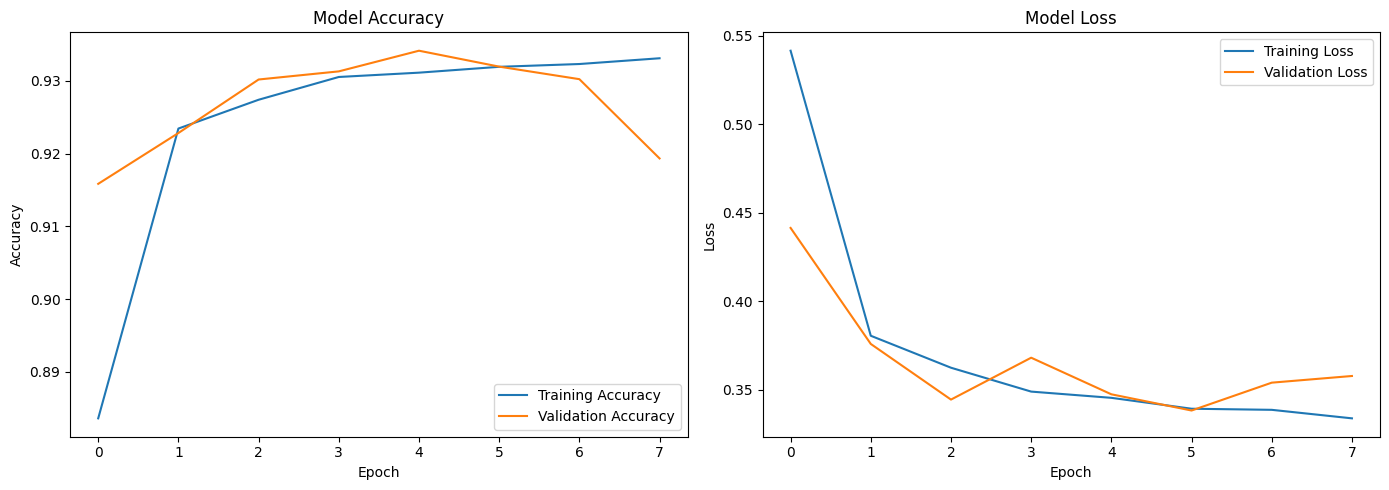

In [16]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


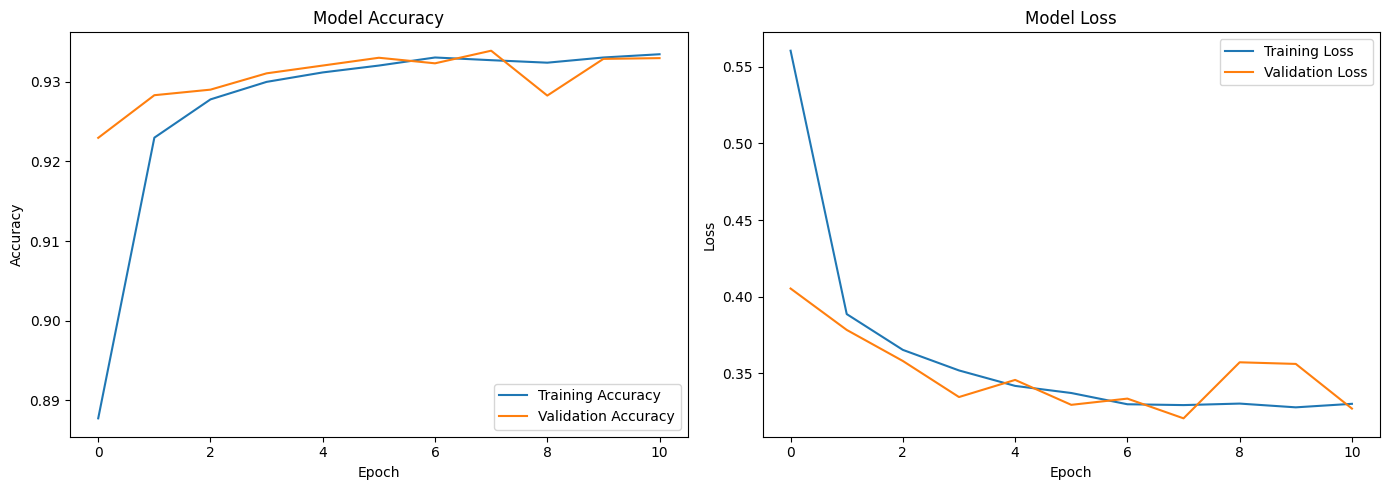

In [107]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


#### Model predictions

In [18]:
y_pred = model.predict([X_ml_test, X_text_test]) 
labels_pred = np.where(y_pred > 0.5, 1, 0)
print(classification_report(y_test, labels_pred))
print(confusion_matrix(y_test, labels_pred))

c:\Users\spooj\Downloads\dsa4266\fake_news\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_5']. Received: the structure of inputs=('*', '*')
  warnings.warn(


839/839 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     13059
           1       0.94      0.93      0.94     13781

    accuracy                           0.93     26840
   macro avg       0.93      0.93      0.93     26840
weighted avg       0.93      0.93      0.93     26840

[[12210   849]
 [  898 12883]]


In [108]:
y_pred = model.predict([X_ml_test, X_text_test]) 
labels_pred = np.where(y_pred > 0.5, 1, 0)
print(classification_report(y_test, labels_pred))
print(confusion_matrix(y_test, labels_pred))

839/839 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     13059
           1       0.93      0.94      0.94     13781

    accuracy                           0.93     26840
   macro avg       0.93      0.93      0.93     26840
weighted avg       0.93      0.93      0.93     26840

[[12146   913]
 [  872 12909]]


(array([  64.,   79.,   89.,   84.,  123.,  189.,  803., 8390., 3591.,
         320.]),
 array([0.5011273 , 0.55011427, 0.59910119, 0.6480881 , 0.69707507,
        0.74606204, 0.79504895, 0.84403586, 0.89302284, 0.94200981,
        0.99099672]),
 <BarContainer object of 10 artists>)

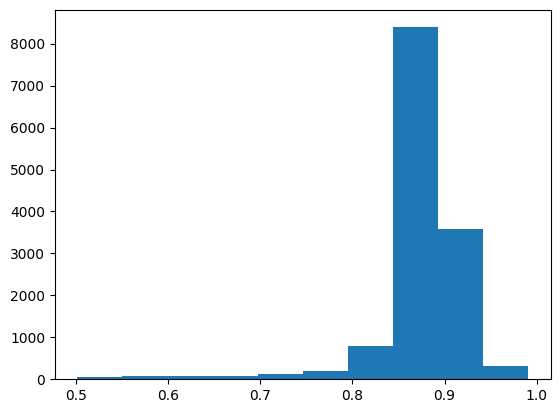

In [19]:
y_distr_pos = y_pred[y_pred > 0.5]
plt.hist(y_distr_pos)

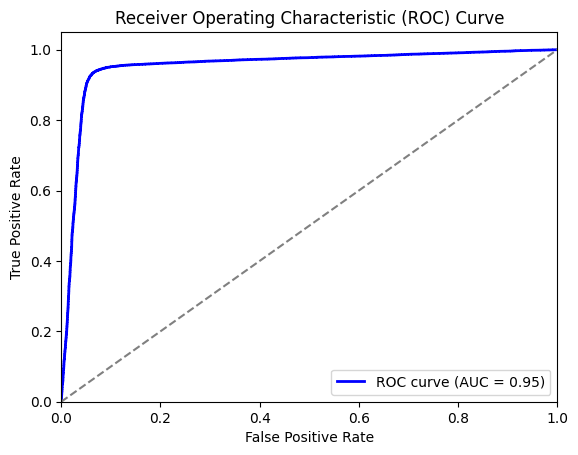

In [20]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


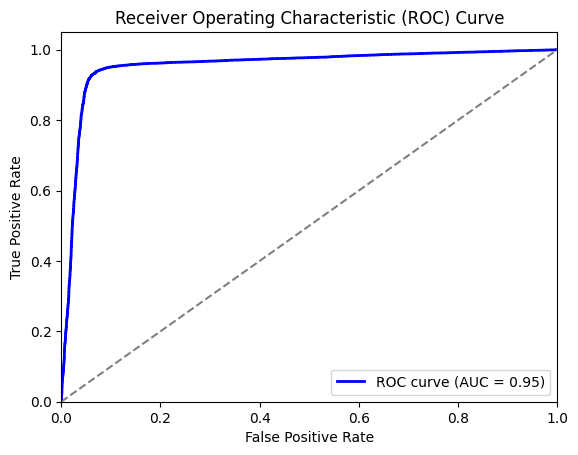

In [109]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


### Model (text + 10)

In [30]:
from regex import B


initializer = HeUniform(seed = 3)

def create_truth_faker_model(shape, dropout_1, dropout_2):
    # Input for structured ML features
    ml_input = Input(shape=(shape,))
    ml_branch = Dense(128, activation='relu', kernel_initializer=initializer)(ml_input)
    ml_branch = Dropout(dropout_1)(ml_branch)
    ml_branch = Dense(32, activation='relu', kernel_initializer=initializer)(ml_branch)
    ml_branch = BatchNormalization()(ml_branch)

    # Embedding layer
    text_input = Input(shape=(128,))
    text_emb = Embedding(input_dim=50000, output_dim=256, input_length=128, embeddings_regularizer=regularizers.L2(0.001))(text_input)

    # CNN layers for text
    cnn_branch = Conv1D(filters=5, kernel_size=7, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizers.L2(0.001))(text_emb)
    cnn_branch = AveragePooling1D(pool_size=2)(cnn_branch)
    cnn_branch = Conv1D(filters=20, kernel_size=3, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizers.L2(0.001))(cnn_branch)
    cnn_branch = AveragePooling1D(pool_size=2)(cnn_branch)
    cnn_branch= BatchNormalization()(cnn_branch)
    cnn_branch = Flatten()(cnn_branch)

    # Combine both branches (ML features and text features)
    combined = Concatenate()([ml_branch, cnn_branch])

    # Fully connected layers after combining
    combined = Dense(64, activation='relu', kernel_initializer=initializer)(combined)
    combined = Dropout(dropout_2)(combined)
    combined = Dense(16, activation='relu', kernel_initializer=initializer)(combined)

    # Output layer for classification (assuming binary classification: Fake or Real)
    output = Dense(1, activation='sigmoid')(combined)  # Use 'softmax' for multi-class

    # Create and compile the model
    model = Model(inputs=[ml_input, text_input], outputs=output)

    return model


model = create_truth_faker_model(10, 0.4, 0.5)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
checkpoint = ModelCheckpoint('model-50000-10.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
history = model.fit([X_ml_train, X_text_train], y_train, validation_data=([X_ml_val, X_text_val], y_val), epochs=20, batch_size=16, verbose=1, callbacks=[early_stopping, checkpoint])



c:\Users\spooj\Downloads\dsa4266\fake_news\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20


c:\Users\spooj\Downloads\dsa4266\fake_news\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_72', 'keras_tensor_77']. Received: the structure of inputs=('*', '*')
  warnings.warn(


5368/5368 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8451 - loss: 0.8083
Epoch 1: val_accuracy improved from -inf to 0.92288, saving model to model-50000-10.keras
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 466s 84ms/step - accuracy: 0.8451 - loss: 0.8082 - val_accuracy: 0.9229 - val_loss: 0.3901
Epoch 2/20
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9248 - loss: 0.3892
Epoch 2: val_accuracy improved from 0.92288 to 0.92814, saving model to model-50000-10.keras
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 394s 73ms/step - accuracy: 0.9248 - loss: 0.3892 - val_accuracy: 0.9281 - val_loss: 0.3515
Epoch 3/20
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9294 - loss: 0.3654
Epoch 3: val_accuracy improved from 0.92814 to 0.93107, saving model to model-50000-10.keras
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 430s 80ms/step - accuracy: 0.9294 - loss: 0.3654 - val_accuracy: 0.9311 - val_loss: 0.3745
Epoch 4/20
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9335 - loss: 0.3488
Epoch 4: val_

### Predictions 

In [31]:
y_pred = model.predict([X_ml_test, X_text_test]) 
labels_pred = np.where(y_pred > 0.5, 1, 0)
print(classification_report(y_test, labels_pred))
print(confusion_matrix(y_test, labels_pred))

c:\Users\spooj\Downloads\dsa4266\fake_news\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_72', 'keras_tensor_77']. Received: the structure of inputs=('*', '*')
  warnings.warn(


839/839 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     13059
           1       0.94      0.93      0.93     13781

    accuracy                           0.93     26840
   macro avg       0.93      0.93      0.93     26840
weighted avg       0.93      0.93      0.93     26840

[[12210   849]
 [  974 12807]]


### Curves

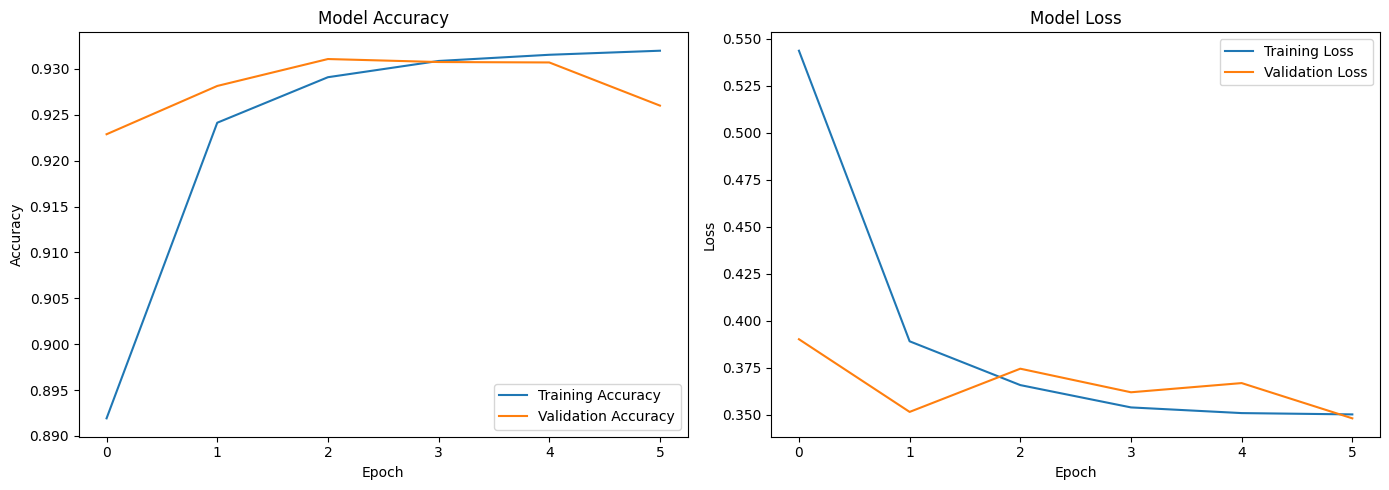

In [34]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


(array([  84.,  100.,   97.,  104.,  174.,  227.,  400., 1168., 7184.,
        4118.]),
 array([0.50103843, 0.55033618, 0.59963393, 0.64893168, 0.69822943,
        0.74752724, 0.79682499, 0.84612274, 0.89542049, 0.94471824,
        0.99401599]),
 <BarContainer object of 10 artists>)

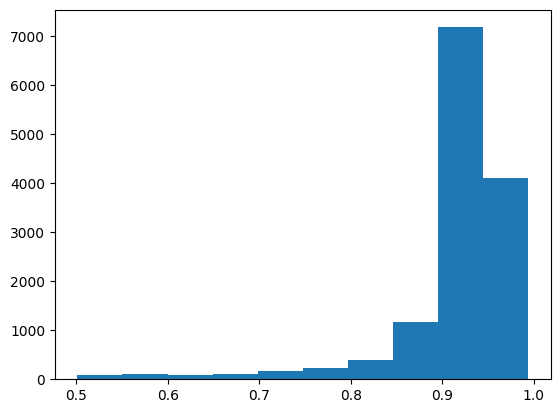

In [32]:
y_distr_pos = y_pred[y_pred > 0.5]
plt.hist(y_distr_pos)

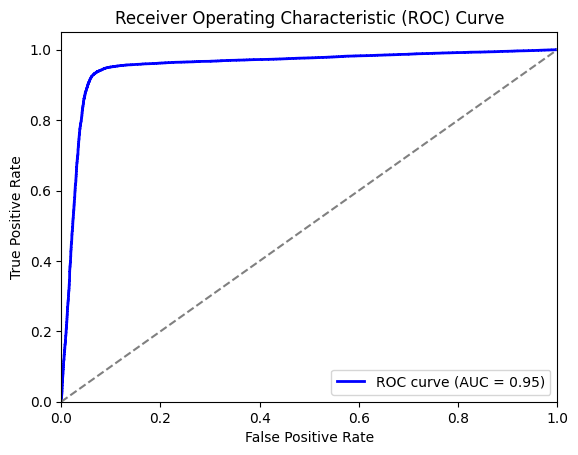

In [33]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## Model (text + 30 features)

In [38]:
from regex import B


initializer = HeUniform(seed = 3)

def create_truth_faker_model(shape, dropout_1, dropout_2):
    # Input for structured ML features
    ml_input = Input(shape=(shape,))
    ml_branch = Dense(128, activation='relu', kernel_initializer=initializer)(ml_input)
    ml_branch = Dropout(dropout_1)(ml_branch)
    ml_branch = Dense(32, activation='relu', kernel_initializer=initializer)(ml_branch)
    ml_branch = BatchNormalization()(ml_branch)

    # Embedding layer
    text_input = Input(shape=(128,))
    text_emb = Embedding(input_dim=50000, output_dim=256, input_length=128, embeddings_regularizer=regularizers.L2(0.001))(text_input)

    # CNN layers for text
    cnn_branch = Conv1D(filters=5, kernel_size=7, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizers.L2(0.001))(text_emb)
    cnn_branch = AveragePooling1D(pool_size=2)(cnn_branch)
    cnn_branch = Conv1D(filters=20, kernel_size=3, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizers.L2(0.001))(cnn_branch)
    cnn_branch = AveragePooling1D(pool_size=2)(cnn_branch)
    cnn_branch= BatchNormalization()(cnn_branch)
    cnn_branch = Flatten()(cnn_branch)

    # Combine both branches (ML features and text features)
    combined = Concatenate()([ml_branch, cnn_branch])

    # Fully connected layers after combining
    combined = Dense(64, activation='relu', kernel_initializer=initializer)(combined)
    combined = Dropout(dropout_2)(combined)
    combined = Dense(16, activation='relu', kernel_initializer=initializer)(combined)

    # Output layer for classification (assuming binary classification: Fake or Real)
    output = Dense(1, activation='sigmoid')(combined)  # Use 'softmax' for multi-class

    # Create and compile the model
    model = Model(inputs=[ml_input, text_input], outputs=output)

    return model


model = create_truth_faker_model(30, 0.4, 0.5)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
checkpoint = ModelCheckpoint('model-50000-30.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
history = model.fit([X_ml_train, X_text_train], y_train, validation_data=([X_ml_val, X_text_val], y_val), epochs=20, batch_size=16, verbose=1, callbacks=[early_stopping, checkpoint])



Epoch 1/20


c:\Users\spooj\Downloads\dsa4266\fake_news\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_108', 'keras_tensor_113']. Received: the structure of inputs=('*', '*')
  warnings.warn(


5368/5368 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8424 - loss: 0.7913
Epoch 1: val_accuracy improved from -inf to 0.91906, saving model to model-50000-30.keras
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 371s 68ms/step - accuracy: 0.8424 - loss: 0.7913 - val_accuracy: 0.9191 - val_loss: 0.4083
Epoch 2/20
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9245 - loss: 0.3898
Epoch 2: val_accuracy improved from 0.91906 to 0.92409, saving model to model-50000-30.keras
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 374s 70ms/step - accuracy: 0.9245 - loss: 0.3898 - val_accuracy: 0.9241 - val_loss: 0.3624
Epoch 3/20
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9294 - loss: 0.3612
Epoch 3: val_accuracy improved from 0.92409 to 0.92982, saving model to model-50000-30.keras
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 375s 70ms/step - accuracy: 0.9294 - loss: 0.3612 - val_accuracy: 0.9298 - val_loss: 0.3535
Epoch 4/20
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9320 - loss: 0.3492
Epoch 4: val_

### Predictions

In [39]:
y_pred = model.predict([X_ml_test, X_text_test]) 
labels_pred = np.where(y_pred > 0.5, 1, 0)
print(classification_report(y_test, labels_pred))
print(confusion_matrix(y_test, labels_pred))

839/839 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     13059
           1       0.93      0.94      0.94     13781

    accuracy                           0.93     26840
   macro avg       0.93      0.93      0.93     26840
weighted avg       0.93      0.93      0.93     26840

[[12162   897]
 [  879 12902]]


### Curves

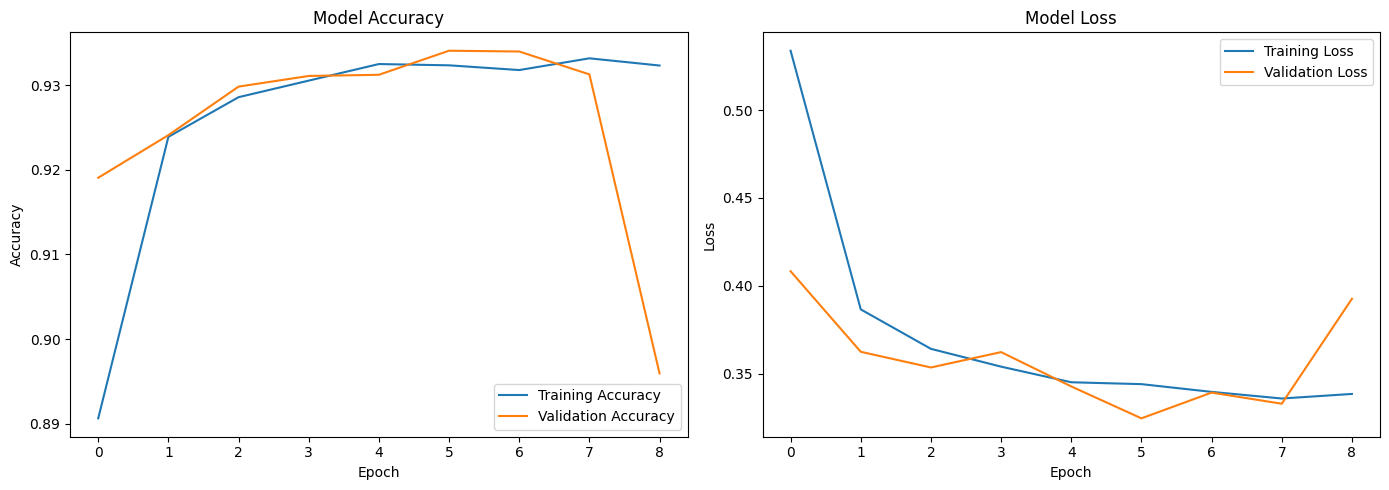

In [40]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


(array([  74.,   71.,   82.,   93.,   97.,  138.,  207.,  480., 3124.,
        9433.]),
 array([0.50222886, 0.55095142, 0.59967405, 0.64839661, 0.69711924,
        0.7458418 , 0.79456437, 0.84328699, 0.89200956, 0.94073218,
        0.98945475]),
 <BarContainer object of 10 artists>)

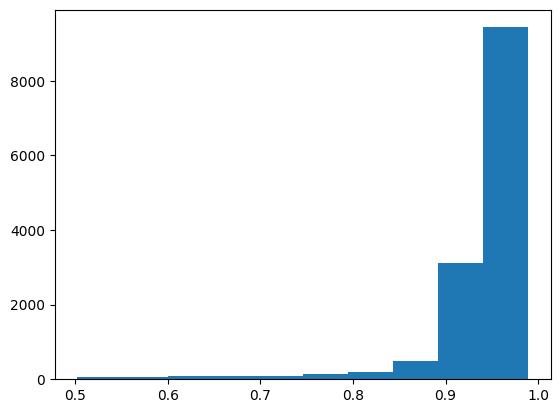

In [41]:
y_distr_pos = y_pred[y_pred > 0.5]
plt.hist(y_distr_pos)

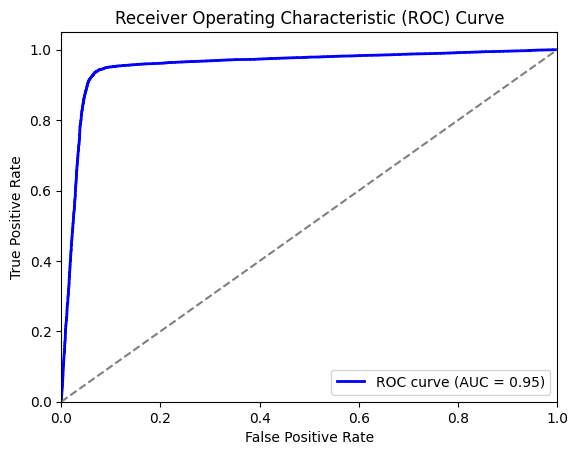

In [42]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## Model (text only)

In [13]:
from regex import B


initializer = HeUniform(seed = 3)

def create_truth_faker_model(dropout_2):
    # Embedding layer
    text_input = Input(shape=(128,))
    text_emb = Embedding(input_dim=50000, output_dim=256, input_length=128, embeddings_regularizer=regularizers.L2(0.001))(text_input)

    # CNN layers for text
    cnn_branch = Conv1D(filters=5, kernel_size=7, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizers.L2(0.001))(text_emb)
    cnn_branch = AveragePooling1D(pool_size=2)(cnn_branch)
    cnn_branch = Conv1D(filters=20, kernel_size=3, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizers.L2(0.001))(cnn_branch)
    cnn_branch = AveragePooling1D(pool_size=2)(cnn_branch)
    cnn_branch= BatchNormalization()(cnn_branch)
    cnn_branch = Flatten()(cnn_branch)

    # Combine both branches (ML features and text features)

    combined = Dense(64, activation='relu', kernel_initializer=initializer)(cnn_branch)
    combined = Dropout(dropout_2)(combined)
    combined = Dense(16, activation='relu', kernel_initializer=initializer)(cnn_branch)

    # Output layer for classification (assuming binary classification: Fake or Real)
    output = Dense(1, activation='sigmoid')(combined)  # Use 'softmax' for multi-class

    # Create and compile the model
    model = Model(inputs=text_input, outputs=output)

    return model


from keras.optimizers import Adam
model = create_truth_faker_model(0.5)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('model-50000-text-1.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
history = model.fit(X_text_train, y_train, validation_data=(X_text_val, y_val), epochs=20, batch_size=16, verbose=1, callbacks=[early_stopping, checkpoint])



c:\Users\spooj\Downloads\dsa4266\fake_news\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8055 - loss: 2.2013
Epoch 1: val_accuracy improved from -inf to 0.91533, saving model to model-50000-text-1.keras
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 371s 68ms/step - accuracy: 0.8055 - loss: 2.2011 - val_accuracy: 0.9153 - val_loss: 0.4597
Epoch 2/20
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9328 - loss: 0.3894
Epoch 2: val_accuracy improved from 0.91533 to 0.92968, saving model to model-50000-text-1.keras
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 361s 67ms/step - accuracy: 0.9328 - loss: 0.3894 - val_accuracy: 0.9297 - val_loss: 0.3544
Epoch 3/20
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9411 - loss: 0.3112
Epoch 3: val_accuracy improved from 0.92968 to 0.93047, saving model to model-50000-text-1.keras
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 381s 71ms/step - accuracy: 0.9411 - loss: 0.3112 - val_accuracy: 0.9305 - val_loss: 0.3332
Epoch 4/20
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9477 - los

In [115]:
from regex import B


initializer = HeUniform(seed = 3)

def create_truth_faker_model(dropout_2):
    # Embedding layer
    text_input = Input(shape=(128,))
    text_emb = Embedding(input_dim=50000, output_dim=256, input_length=128, embeddings_regularizer=regularizers.L2(0.001))(text_input)

    # CNN layers for text
    cnn_branch = Conv1D(filters=5, kernel_size=7, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizers.L2(0.001))(text_emb)
    cnn_branch = AveragePooling1D(pool_size=2)(cnn_branch)
    cnn_branch = Conv1D(filters=20, kernel_size=3, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizers.L2(0.001))(cnn_branch)
    cnn_branch = AveragePooling1D(pool_size=2)(cnn_branch)
    cnn_branch= BatchNormalization()(cnn_branch)
    cnn_branch = Flatten()(cnn_branch)

    # Combine both branches (ML features and text features)

    combined = Dense(64, activation='relu', kernel_initializer=initializer)(cnn_branch)
    combined = Dropout(dropout_2)(combined)
    combined = Dense(16, activation='relu', kernel_initializer=initializer)(cnn_branch)

    # Output layer for classification (assuming binary classification: Fake or Real)
    output = Dense(1, activation='sigmoid')(combined)  # Use 'softmax' for multi-class

    # Create and compile the model
    model = Model(inputs=text_input, outputs=output)

    return model


from keras.optimizers import Adam
model = create_truth_faker_model(0.4)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('model-50000-text-3.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
history = model.fit(X_text_train, y_train, validation_data=(X_text_val, y_val), epochs=20, batch_size=16, verbose=1, callbacks=[early_stopping, checkpoint])



c:\Users\spooj\Downloads\dsa4266\fake_news\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7954 - loss: 2.1888
Epoch 1: val_accuracy improved from -inf to 0.92874, saving model to model-50000-text-3.keras
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 389s 72ms/step - accuracy: 0.7955 - loss: 2.1886 - val_accuracy: 0.9287 - val_loss: 0.4249
Epoch 2/20
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9367 - loss: 0.3724
Epoch 2: val_accuracy improved from 0.92874 to 0.93135, saving model to model-50000-text-3.keras
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 411s 77ms/step - accuracy: 0.9367 - loss: 0.3724 - val_accuracy: 0.9314 - val_loss: 0.3435
Epoch 3/20
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9434 - loss: 0.3022
Epoch 3: val_accuracy improved from 0.93135 to 0.93429, saving model to model-50000-text-3.keras
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 474s 88ms/step - accuracy: 0.9434 - loss: 0.3022 - val_accuracy: 0.9343 - val_loss: 0.3233
Epoch 4/20
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9480 - los

In [111]:
from regex import B
from sympy import Max


initializer = HeUniform(seed = 3)

def create_truth_faker_model(dropout_2):
    # Embedding layer
    text_input = Input(shape=(128,))
    text_emb = Embedding(input_dim=50000, output_dim=256, input_length=128, embeddings_regularizer=regularizers.L2(0.001))(text_input)

    # CNN layers for text
    cnn_branch = Conv1D(filters=5, kernel_size=7, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizers.L2(0.001))(text_emb)
    cnn_branch = MaxPooling1D(pool_size=2)(cnn_branch)
    cnn_branch = Conv1D(filters=20, kernel_size=3, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizers.L2(0.001))(cnn_branch)
    cnn_branch = MaxPooling1D(pool_size=2)(cnn_branch)
    cnn_branch= BatchNormalization()(cnn_branch)
    cnn_branch = Flatten()(cnn_branch)

    # Combine both branches (ML features and text features)

    combined = Dense(64, activation='relu', kernel_initializer=initializer)(cnn_branch)
    combined = Dropout(dropout_2)(combined)
    combined = Dense(16, activation='relu', kernel_initializer=initializer)(cnn_branch)

    # Output layer for classification (assuming binary classification: Fake or Real)
    output = Dense(1, activation='sigmoid')(combined)  # Use 'softmax' for multi-class

    # Create and compile the model
    model = Model(inputs=text_input, outputs=output)

    return model


from keras.optimizers import Adam
model = create_truth_faker_model(0.5)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('model-50000-text-2.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
history = model.fit(X_text_train, y_train, validation_data=(X_text_val, y_val), epochs=20, batch_size=16, verbose=1, callbacks=[early_stopping, checkpoint])



Epoch 1/20
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7798 - loss: 2.4360
Epoch 1: val_accuracy improved from -inf to 0.92646, saving model to model-50000-text-2.keras
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 396s 73ms/step - accuracy: 0.7798 - loss: 2.4358 - val_accuracy: 0.9265 - val_loss: 0.5477
Epoch 2/20
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9400 - loss: 0.4572
Epoch 2: val_accuracy improved from 0.92646 to 0.92711, saving model to model-50000-text-2.keras
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 381s 71ms/step - accuracy: 0.9400 - loss: 0.4572 - val_accuracy: 0.9271 - val_loss: 0.4244
Epoch 3/20
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9482 - loss: 0.3393
Epoch 3: val_accuracy improved from 0.92711 to 0.92781, saving model to model-50000-text-2.keras
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 378s 70ms/step - accuracy: 0.9482 - loss: 0.3393 - val_accuracy: 0.9278 - val_loss: 0.3854
Epoch 4/20
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9548 - los

In [23]:
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_7 (Embedding)         │ (None, 128, 256)       │    12,800,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 122, 5)         │         8,965 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 61, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, 59, 20)         │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 29, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 29, 20)         │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 580)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 16)             │         9,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,455,956 (146.70 MB)

 Trainable params: 12,818,638 (48.90 MB)

 Non-trainable params: 40 (160.00 B)

 Optimizer params: 25,637,278 (97.80 MB)

In [22]:
from torch import ne


model = load_model('model-50000-text-2.keras')
netron.start('model-50000-text-2.keras')

Serving 'model-50000-text-2.keras' at http://localhost:8081


('localhost', 8081)

### Model Prediction

In [45]:
y_pred = model.predict(X_text_test) 
labels_pred = np.where(y_pred > 0.5, 1, 0)
print(classification_report(y_test, labels_pred))
print(confusion_matrix(y_test, labels_pred))

839/839 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     13059
           1       0.94      0.94      0.94     13781

    accuracy                           0.93     26840
   macro avg       0.93      0.93      0.93     26840
weighted avg       0.93      0.93      0.93     26840

[[12163   896]
 [  891 12890]]


In [14]:
# 0.0001 LR
y_pred = model.predict(X_text_test) 
labels_pred = np.where(y_pred > 0.5, 1, 0)
print(classification_report(y_test, labels_pred))
print(confusion_matrix(y_test, labels_pred))

839/839 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     13059
           1       0.93      0.94      0.93     13781

    accuracy                           0.93     26840
   macro avg       0.93      0.93      0.93     26840
weighted avg       0.93      0.93      0.93     26840

[[12021  1038]
 [  817 12964]]


In [112]:
# Average Pooling
y_pred = model.predict(X_text_test) 
labels_pred = np.where(y_pred > 0.5, 1, 0)
print(classification_report(y_test, labels_pred))
print(confusion_matrix(y_test, labels_pred))

839/839 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
              precision    recall  f1-score   support

           0       0.93      0.92      0.93     13059
           1       0.93      0.93      0.93     13781

    accuracy                           0.93     26840
   macro avg       0.93      0.93      0.93     26840
weighted avg       0.93      0.93      0.93     26840

[[12041  1018]
 [  904 12877]]


In [116]:
# Dropout 0.4
y_pred = model.predict(X_text_test) 
labels_pred = np.where(y_pred > 0.5, 1, 0)
print(classification_report(y_test, labels_pred))
print(confusion_matrix(y_test, labels_pred))

839/839 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     13059
           1       0.94      0.94      0.94     13781

    accuracy                           0.93     26840
   macro avg       0.93      0.93      0.93     26840
weighted avg       0.93      0.93      0.93     26840

[[12172   887]
 [  893 12888]]


### Curves

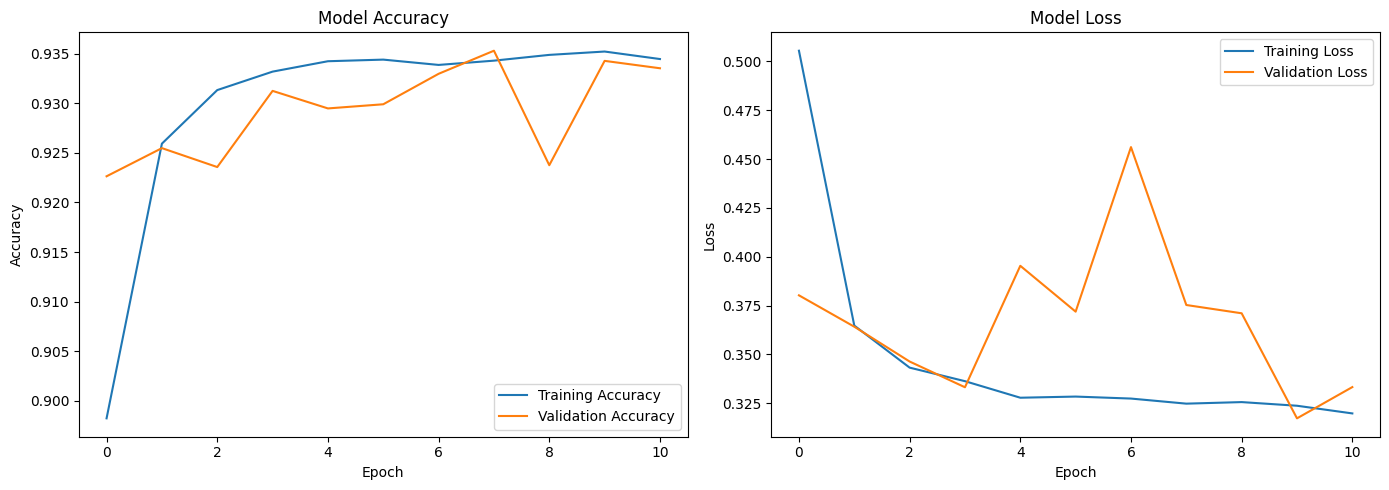

In [46]:
# 0.01 LR
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


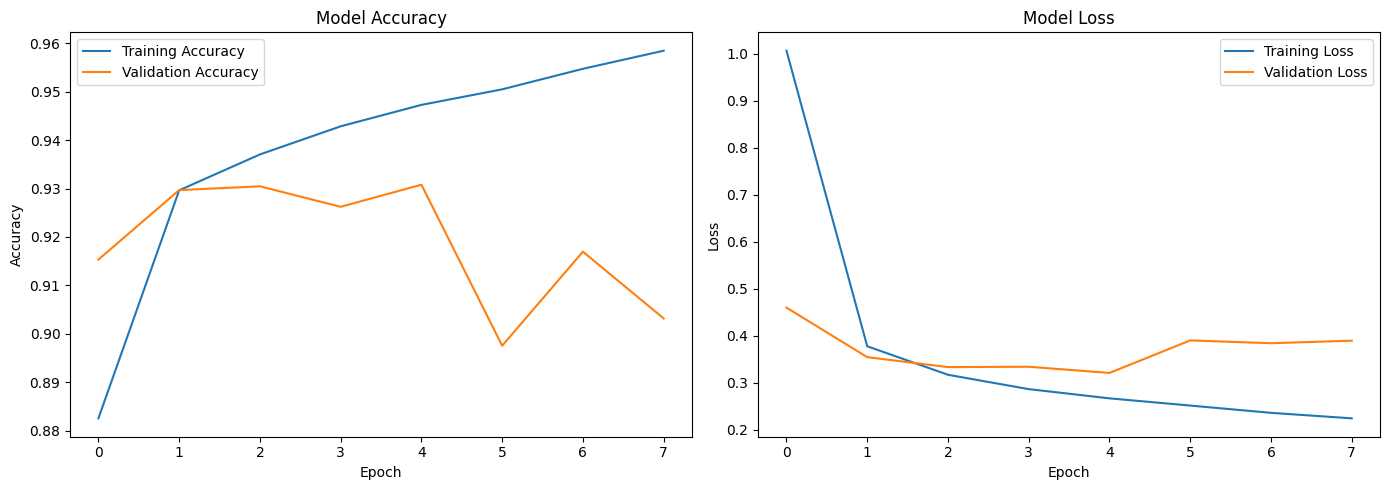

In [16]:
# 0.0001 LR
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


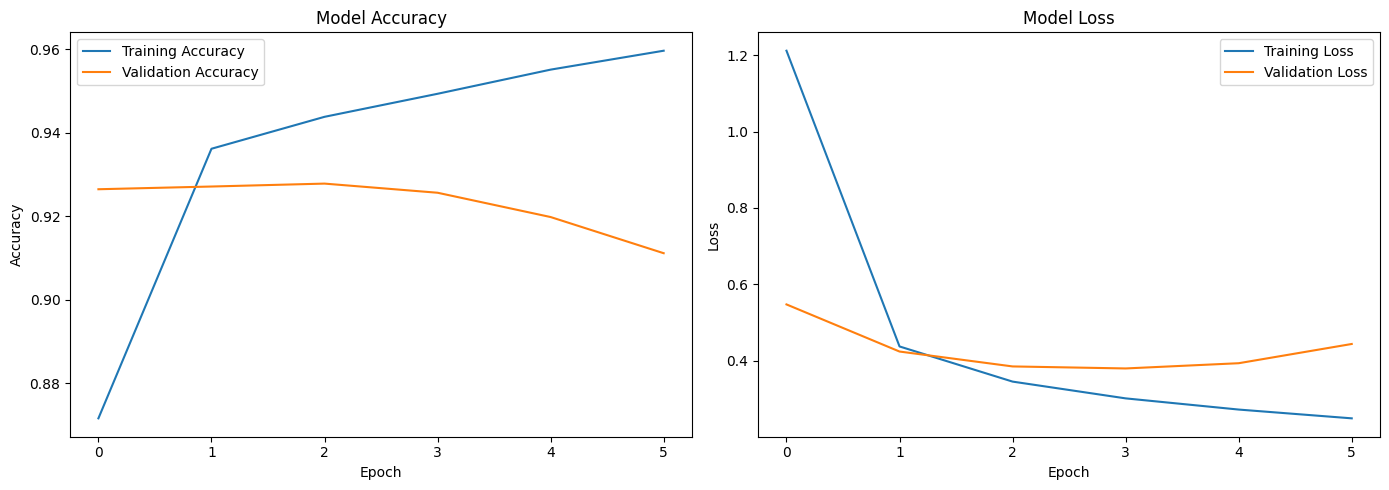

In [113]:
# Average Pooling
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


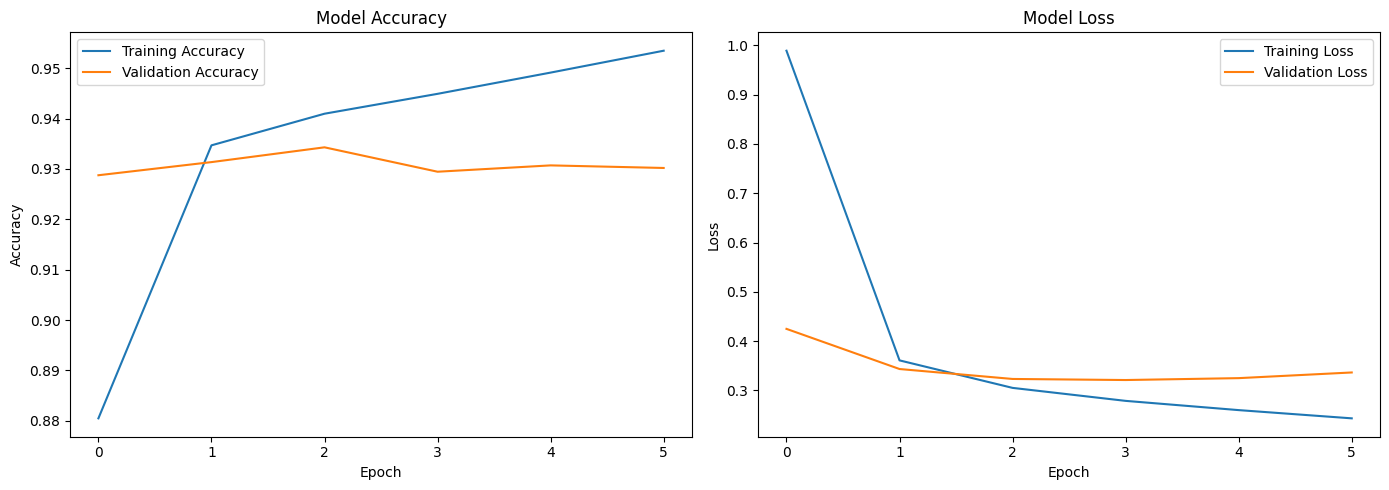

In [117]:
# Dropout 0.4
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


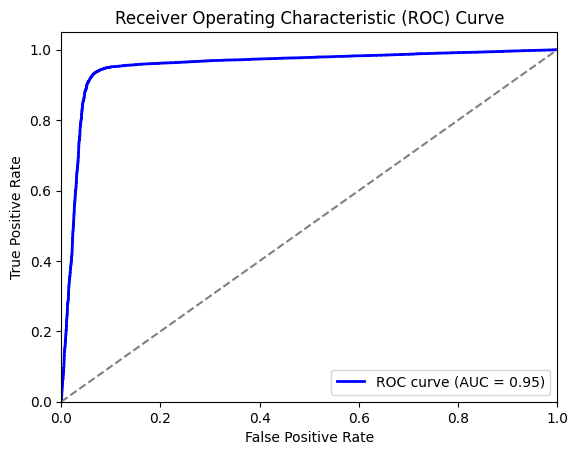

In [48]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


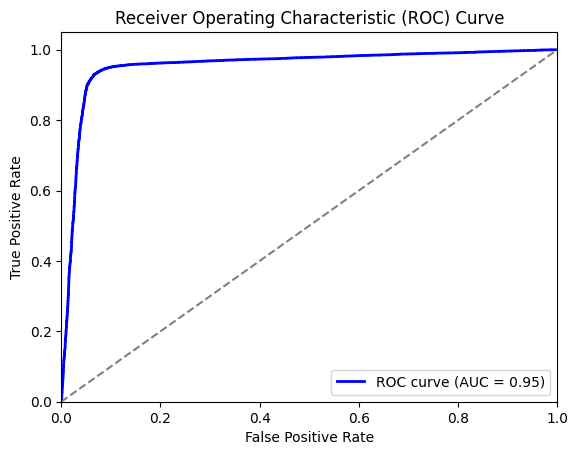

In [17]:
# 0.0001 LR
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


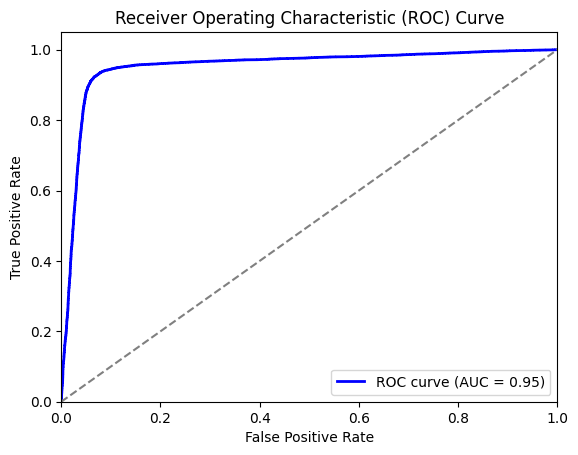

In [114]:
# 0.0001 LR
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


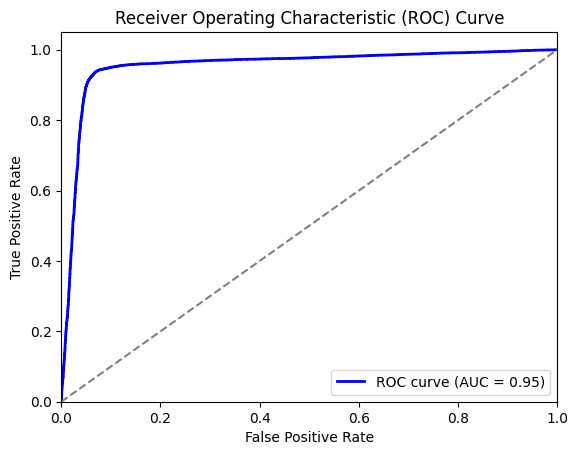

In [118]:
# Dropout 0.4
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## Model Embeddings Viz

In [81]:
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, AveragePooling1D, BatchNormalization, Flatten, Dense, Dropout
from keras import regularizers
from keras.initializers import HeUniform
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import Adam
import os
import tensorflow as tf

initializer = HeUniform(seed=3)

def create_truth_faker_model(dropout_2):
    # Embedding layer
    text_input = Input(shape=(128,))
    text_emb = Embedding(input_dim=50000, output_dim=256, input_length=128, embeddings_regularizer=regularizers.L2(0.001))(text_input)

    # CNN layers for text
    cnn_branch = Conv1D(filters=5, kernel_size=7, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizers.L2(0.001))(text_emb)
    cnn_branch = AveragePooling1D(pool_size=2)(cnn_branch)
    cnn_branch = Conv1D(filters=20, kernel_size=3, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizers.L2(0.001))(cnn_branch)
    cnn_branch = AveragePooling1D(pool_size=2)(cnn_branch)
    cnn_branch = BatchNormalization()(cnn_branch)
    cnn_branch = Flatten()(cnn_branch)

    # Fully connected layers
    combined = Dense(64, activation='relu', kernel_initializer=initializer)(cnn_branch)
    combined = Dropout(dropout_2)(combined)  # Apply dropout to combined
    combined = Dense(16, activation='relu', kernel_initializer=initializer)(combined)

    # Output layer for classification
    output = Dense(1, activation='sigmoid')(combined)  # Use 'softmax' for multi-class

    # Create and compile the model
    model = Model(inputs=text_input, outputs=output)

    return model

# Compile the model
model = create_truth_faker_model(0.5)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Set up the callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('model-50000-text-viz.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

# Set up TensorBoard callback for embedding visualization
log_dir = os.path.join("logs", "fit")  # Specify the directory for TensorBoard logs
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, embeddings_freq=1, 
                                   )

# Train the model with TensorBoard
history = model.fit(X_text_train, y_train, validation_data=(X_text_val, y_val), epochs=20, batch_size=16, verbose=1,
                    callbacks=[early_stopping, checkpoint, tensorboard_callback])


Epoch 1/20
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7663 - loss: 2.2896
Epoch 1: val_accuracy improved from -inf to 0.92423, saving model to model-50000-text-viz.keras
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 389s 71ms/step - accuracy: 0.7664 - loss: 2.2894 - val_accuracy: 0.9242 - val_loss: 0.4681
Epoch 2/20
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9312 - loss: 0.4271
Epoch 2: val_accuracy improved from 0.92423 to 0.92837, saving model to model-50000-text-viz.keras
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 392s 73ms/step - accuracy: 0.9312 - loss: 0.4271 - val_accuracy: 0.9284 - val_loss: 0.3659
Epoch 3/20
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9385 - loss: 0.3355
Epoch 3: val_accuracy improved from 0.92837 to 0.93000, saving model to model-50000-text-viz.keras
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 410s 76ms/step - accuracy: 0.9385 - loss: 0.3355 - val_accuracy: 0.9300 - val_loss: 0.3373
Epoch 4/20
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9433

In [82]:
y_pred = model.predict(X_text_test)
labels = np.where(y_pred > 0.5, 1, 0)
print(classification_report(y_test, labels))
print(confusion_matrix(y_test, labels))

839/839 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     13059
           1       0.94      0.93      0.93     13781

    accuracy                           0.93     26840
   macro avg       0.93      0.93      0.93     26840
weighted avg       0.93      0.93      0.93     26840

[[12183   876]
 [  923 12858]]


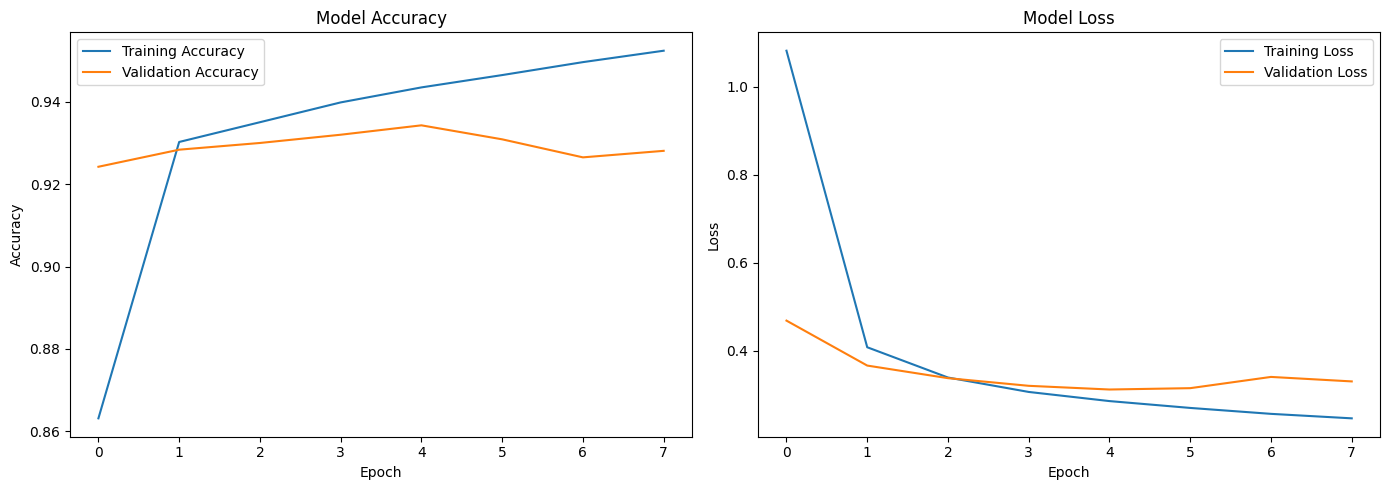

In [84]:
# 0.01 LR
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


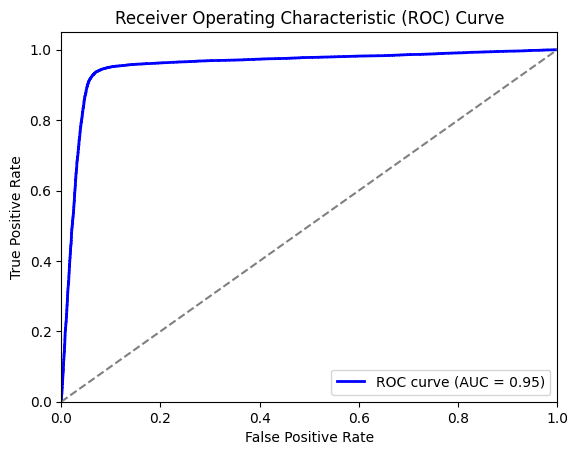

In [83]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## Model numerical features only

In [25]:
from regex import B


initializer = HeUniform(seed = 3)

def create_truth_faker_model(shape, dropout_1):
    # Input for structured ML features
    ml_input = Input(shape=(shape,))
    ml_branch = Dense(128, activation='relu', kernel_initializer=initializer)(ml_input)
    ml_branch = Dropout(dropout_1)(ml_branch)
    ml_branch = BatchNormalization()(ml_branch)

    ml_branch_reshaped = Reshape((32, 4))(ml_branch)  # for Conv1D

    # Add Conv1D Layers (for sequence-like data)
    conv_branch = Conv1D(30, kernel_size=3, activation='relu', kernel_initializer=initializer)(ml_branch_reshaped)
    conv_branch = Conv1D(32, kernel_size=3, activation='relu', kernel_initializer=initializer)(conv_branch)
    conv_branch = Flatten()(conv_branch)

    # Output layer for classification (assuming binary classification: Fake or Real)
    output = Dense(1, activation='sigmoid')(ml_branch)  # Use 'softmax' for multi-class

    # Create and compile the model
    model = Model(inputs=ml_input, outputs=output)

    return model


model = create_truth_faker_model(30, 0.4)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
checkpoint = ModelCheckpoint('model-50000-25-only.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
history = model.fit(X_ml_train, y_train, validation_data=(X_ml_val, y_val), epochs=20, batch_size=16, verbose=1, callbacks=[early_stopping, checkpoint])



Epoch 1/20
5365/5368 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5800 - loss: 0.7017
Epoch 1: val_accuracy improved from -inf to 0.61853, saving model to model-50000-25-only.keras
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.5801 - loss: 0.7017 - val_accuracy: 0.6185 - val_loss: 0.6504
Epoch 2/20
5359/5368 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6110 - loss: 0.6546
Epoch 2: val_accuracy improved from 0.61853 to 0.62155, saving model to model-50000-25-only.keras
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.6110 - loss: 0.6546 - val_accuracy: 0.6216 - val_loss: 0.6475
Epoch 3/20
5341/5368 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6168 - loss: 0.6526
Epoch 3: val_accuracy did not improve from 0.62155
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6168 - loss: 0.6526 - val_accuracy: 0.6196 - val_loss: 0.6478
Epoch 4/20
5363/5368 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6189 - loss: 0.6510
Epoch 4: val_accuracy improved from 0.62155 t

### Predictions

In [29]:
y_pred = model.predict(X_ml_test) 
labels_pred = np.where(y_pred > 0.5, 1, 0)
print(classification_report(y_test, labels_pred))
print(confusion_matrix(y_test, labels_pred))

839/839 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
              precision    recall  f1-score   support

           0       0.63      0.60      0.61     13059
           1       0.64      0.67      0.65     13781

    accuracy                           0.63     26840
   macro avg       0.63      0.63      0.63     26840
weighted avg       0.63      0.63      0.63     26840

[[7798 5261]
 [4562 9219]]


### Curves

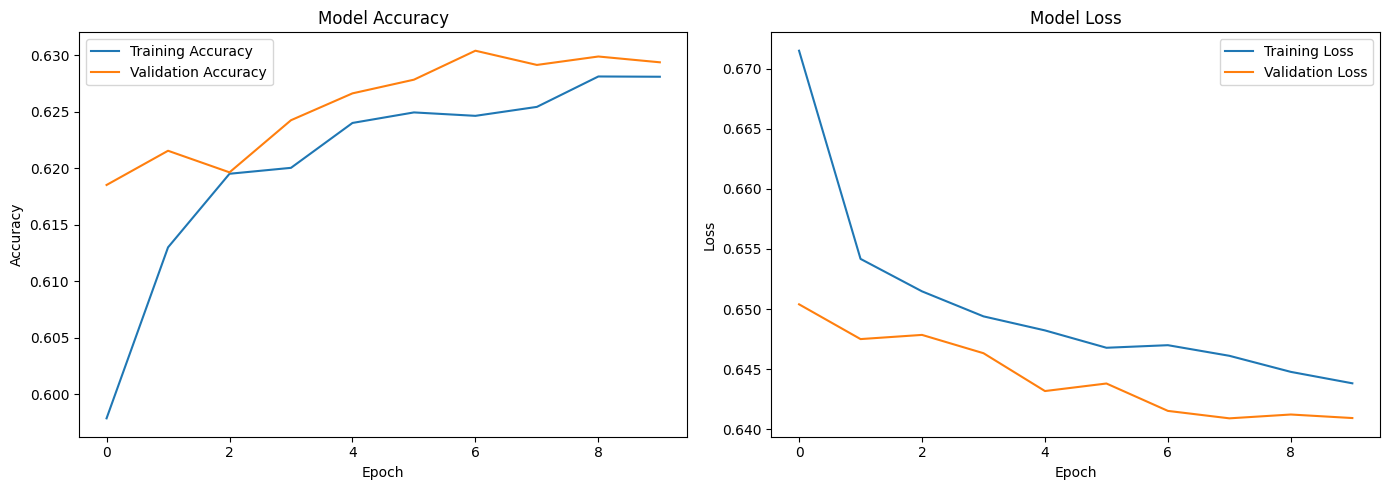

In [26]:
# 0.01 LR
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


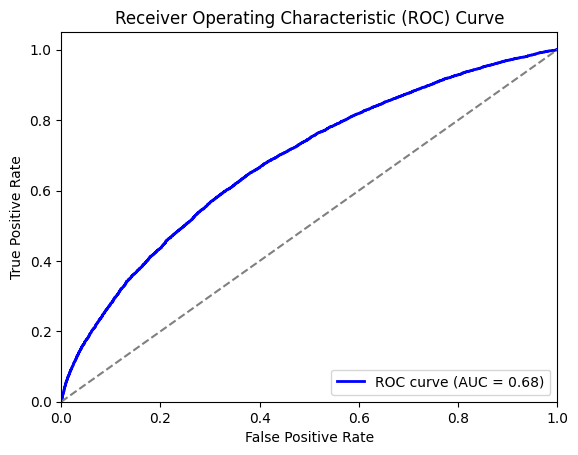

In [30]:
# 0.001 LR
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## Model(Numerical with ordering)

In [35]:
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.cluster import hierarchy
from scipy.stats import spearmanr
from scipy.spatial.distance import squareform

In [34]:
df_clean_filtered

,followers_count,friends_count,favourites_count,statuses_count,listed_count,cred,normalize_influence,mentions,hashtags,URLs,...,present_verbs,past_verbs,adjectives,pronouns,TOs,determiners,dots,exclamation,capitals,short_word_freq
0,4262.0,3619.0,34945.0,16423.0,44.0,0.540794,0.104602,1.0,0.0,1.0,...,1,1,1,1,0,0,5,0,33,19
1,1393.0,1621.0,31436.0,37184.0,64.0,0.462177,0.094436,3.0,0.0,1.0,...,7,2,2,8,2,0,1,0,14,34
2,9.0,84.0,219.0,1184.0,0.0,0.096774,0.039846,0.0,0.0,1.0,...,0,0,7,0,1,0,0,0,3,10
3,4262.0,3619.0,34945.0,16423.0,44.0,0.540794,0.104602,1.0,0.0,1.0,...,4,6,3,1,1,0,3,0,6,30
4,70.0,166.0,15282.0,2194.0,0.0,0.296610,0.061135,1.0,0.0,1.0,...,2,2,2,2,0,0,3,0,11,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134193,2075.0,2662.0,156306.0,62375.0,3.0,0.438041,0.098915,0.0,0.0,1.0,...,4,3,2,2,0,0,1,0,31,32
134194,1636.0,1626.0,215290.0,44011.0,10.0,0.501533,0.096203,0.0,0.0,0.0,...,3,0,1,2,0,0,1,0,16,8
134195,286.0,2501.0,28377.0,7617.0,1.0,0.102619,0.076870,1.0,0.0,1.0,...,7,2,5,4,2,1,1,0,2,37
134196,2.0,45.0,16.0,509.0,0.0,0.042553,0.024038,1.0,0.0,1.0,...,3,0,3,1,0,1,3,0,0,11


In [41]:
import pandas as pd

# Assuming your data is in a pandas DataFrame 'df'
correlation_matrix = df_clean_filtered.corr()
from scipy.cluster.hierarchy import linkage, fcluster
import numpy as np

# Perform hierarchical clustering on the correlation matrix
Z = linkage(1 - correlation_matrix, 'ward')

# Get the cluster labels based on the number of clusters you want (e.g., 1 cluster per correlated group)
clusters = fcluster(Z, t=1.0, criterion='distance')

# Sort features by their cluster labels
feature_order = np.argsort(clusters)
df_rearranged = df_clean_filtered.iloc[:, feature_order]
scaler = StandardScaler()
X_clean = scaler.fit_transform(df_clean_filtered)


C:\Users\spooj\AppData\Local\Temp\ipykernel_24164\2832587255.py:9: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(1 - correlation_matrix, 'ward')


In [42]:
X_ml_train, X_ml_test, X_text_train, X_text_test, y_train, y_test = train_test_split(X_clean, text_padded, labels, test_size=0.2, random_state=42)
X_ml_train, X_ml_val, X_text_train, X_text_val, y_train, y_val = train_test_split(X_ml_train, X_text_train, y_train, test_size=0.2, random_state = 42)

In [43]:
from regex import B


initializer = HeUniform(seed = 3)

def create_truth_faker_model(shape, dropout_1):
    # Input for structured ML features
    ml_input = Input(shape=(shape,))
    ml_branch = Dense(128, activation='relu', kernel_initializer=initializer)(ml_input)
    ml_branch = Dropout(dropout_1)(ml_branch)
    ml_branch = BatchNormalization()(ml_branch)

    ml_branch_reshaped = Reshape((32, 4))(ml_branch)  # for Conv1D

    # Add Conv1D Layers (for sequence-like data)
    conv_branch = Conv1D(30, kernel_size=3, activation='relu', kernel_initializer=initializer)(ml_branch_reshaped)
    conv_branch = Conv1D(32, kernel_size=3, activation='relu', kernel_initializer=initializer)(conv_branch)
    conv_branch = Flatten()(conv_branch)

    # Output layer for classification (assuming binary classification: Fake or Real)
    output = Dense(1, activation='sigmoid')(ml_branch)  # Use 'softmax' for multi-class

    # Create and compile the model
    model = Model(inputs=ml_input, outputs=output)

    return model


model = create_truth_faker_model(30, 0.4)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
checkpoint = ModelCheckpoint('model-50000-25-only.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
history = model.fit(X_ml_train, y_train, validation_data=(X_ml_val, y_val), epochs=20, batch_size=16, verbose=1, callbacks=[early_stopping, checkpoint])



Epoch 1/20
5344/5368 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5791 - loss: 0.6973
Epoch 1: val_accuracy improved from -inf to 0.61657, saving model to model-50000-25-only.keras
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.5791 - loss: 0.6971 - val_accuracy: 0.6166 - val_loss: 0.6498
Epoch 2/20
5343/5368 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6108 - loss: 0.6562
Epoch 2: val_accuracy improved from 0.61657 to 0.62253, saving model to model-50000-25-only.keras
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.6108 - loss: 0.6562 - val_accuracy: 0.6225 - val_loss: 0.6468
Epoch 3/20
5367/5368 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6192 - loss: 0.6518
Epoch 3: val_accuracy improved from 0.62253 to 0.62472, saving model to model-50000-25-only.keras
5368/5368 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6192 - loss: 0.6518 - val_accuracy: 0.6247 - val_loss: 0.6470
Epoch 4/20
5366/5368 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6199 - loss: 0.6502

In [44]:
y_pred = model.predict(X_ml_test) 
labels_pred = np.where(y_pred > 0.5, 1, 0)
print(classification_report(y_test, labels_pred))
print(confusion_matrix(y_test, labels_pred))

839/839 ━━━━━━━━━━━━━━━━━━━━ 1s 755us/step
              precision    recall  f1-score   support

           0       0.62      0.67      0.64     13059
           1       0.66      0.61      0.63     13781

    accuracy                           0.64     26840
   macro avg       0.64      0.64      0.64     26840
weighted avg       0.64      0.64      0.64     26840

[[8709 4350]
 [5400 8381]]


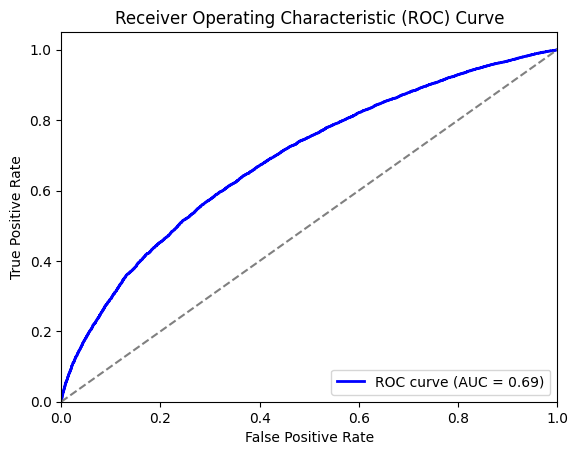

In [45]:
# 0.001 LR
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
